In [1]:
import pandas as pd
import numpy as np

# Create synthetic data
np.random.seed(42)
num_samples = 1000

size = np.random.normal(1500, 500, num_samples).astype(int)
size = np.clip(size, 800, 3000)  # Ensure reasonable house sizes

num_rooms = np.random.poisson(3, num_samples) + 1  # At least 1 room
location = np.random.choice(['urban', 'suburban', 'rural'], num_samples, p=[0.5, 0.3, 0.2])

# Base price calculation
price = size * 100 + num_rooms * 20000

# Adjust for location
price = np.where(location == 'urban', price * 1.3,
                np.where(location == 'suburban', price * 1.1, price * 0.9))

# Add some noise
price = price + np.random.normal(0, 20000, num_samples)

# Create DataFrame
data = pd.DataFrame({
    'Size': size,
    'Location': location,
    'Number_of_Rooms': num_rooms,
    'Price': price
})

# Save to CSV
data.to_csv('house_prices.csv', index=False)

Dataset shape: (1000, 2)

First 5 rows:
   area      price
0  1567  177067.50
1  3345  511748.20
2  3722  404096.67
3  2783  357916.31
4  2949  362409.54

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   area    1000 non-null   int64  
 1   price   1000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 15.8 KB
None

Descriptive statistics:
              area          price
count  1000.000000    1000.000000
mean   2972.920000  348132.020970
std    1128.465907  142136.964031
min    1002.000000  -19630.310000
25%    2063.500000  249198.307500
50%    2918.500000  348351.020000
75%    3917.750000  449603.300000
max    5000.000000  734120.220000

Missing values per column:
area     0
price    0
dtype: int64


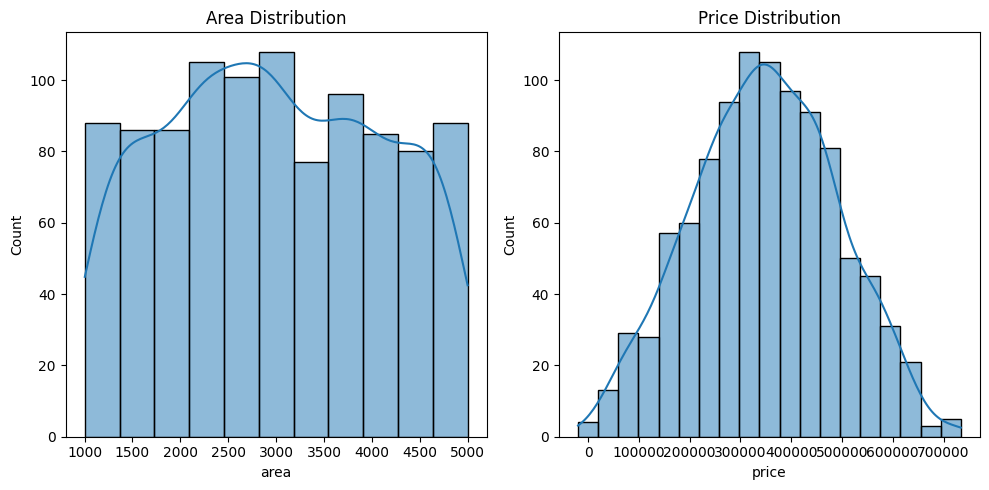

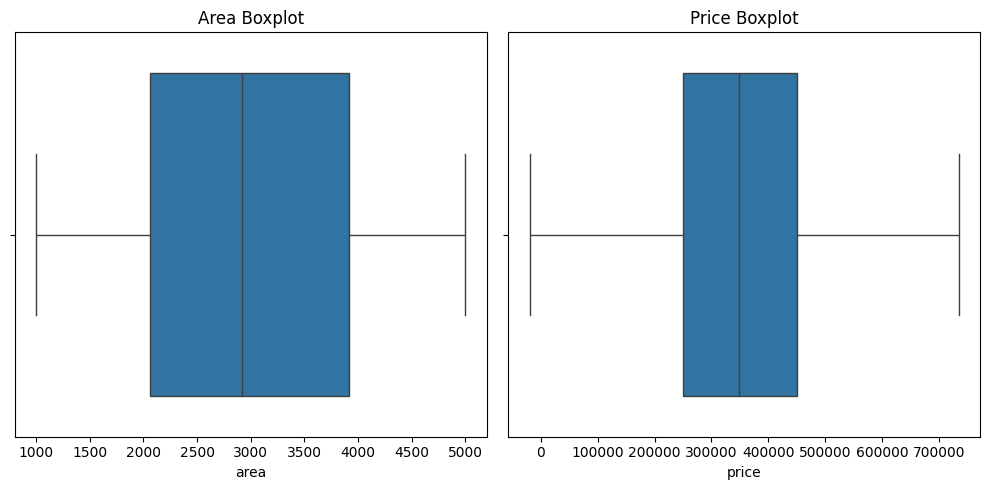

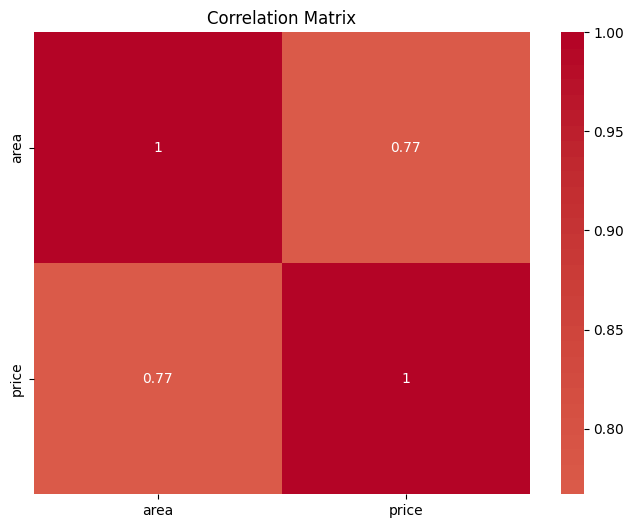

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv('/content/house-prices.csv')

# 1. Initial exploration
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types and missing values:")
print(df.info())
print("\nDescriptive statistics:")
print(df.describe())

# 2. Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# 3. Visualize distributions
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['area'], kde=True)
plt.title('Area Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['price'], kde=True)
plt.title('Price Distribution')

plt.tight_layout()
plt.show()

# 4. Check for outliers
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['area'])
plt.title('Area Boxplot')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['price'])
plt.title('Price Boxplot')

plt.tight_layout()
plt.show()

# 5. Correlation analysis
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

In [5]:
# Define preprocessing steps
numeric_features = ['area']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Remove categorical features as they are not in the loaded data
# categorical_features = ['Location']
# categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        # ('cat', categorical_transformer, categorical_features) # Removed categorical transformer
    ],
    remainder='passthrough' # Keep other columns (like 'price' for now)
)

# Separate features and target
X = df.drop('price', axis=1) # Changed 'Price' to 'price'
y = df['price'] # Changed 'Price' to 'price'

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 800
Test set size: 200


In [7]:
# Create pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
model.fit(X_train, y_train)

# Get feature names after preprocessing
preprocessor.fit(X_train)
feature_names = numeric_features.copy()

# Add one-hot encoded location categories
# location_categories = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(['Location'])
# feature_names.extend(location_categories)

print("\nModel trained successfully!")


Model trained successfully!



Model Performance:
RMSE: 94608.66
R² Score: 0.5945


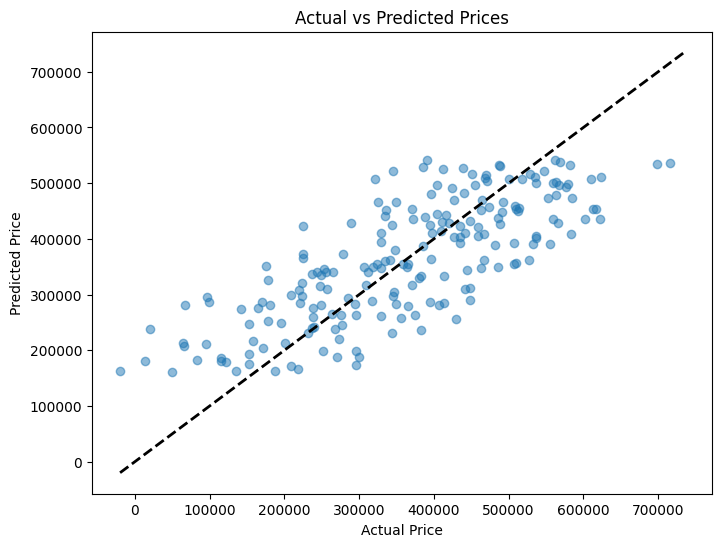


Feature Importance:
  Feature   Coefficient
0    area  107176.41898


In [8]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Visualize predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.show()

# Feature importance
coefficients = model.named_steps['regressor'].coef_
importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
importance = importance.sort_values(by='Coefficient', key=abs, ascending=False)

print("\nFeature Importance:")
print(importance)

In [9]:
# 1. Save the trained model
import joblib
joblib.dump(model, 'house_price_predictor.joblib')

# 2. Save predictions
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions.to_csv('predictions.csv', index=False)

# 3. Save evaluation metrics
metrics = pd.DataFrame({'RMSE': [rmse], 'R2_Score': [r2]})
metrics.to_csv('evaluation_metrics.csv', index=False)

# 4. Save feature insights
importance.to_csv('feature_importance.csv', index=False)

print("\nAll deliverables saved successfully!")


All deliverables saved successfully!
